In [2]:
import os
import numpy as np
import h5py as h5
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import ConnectionPatch, FancyArrowPatch
from datetime import datetime
import argparse
import pdb
from functools import partial
from copy import deepcopy
from tqdm.notebook import tqdm
import pickle as pkl

import jax
import jax.numpy as jnp
import equinox as eqx
import optax

import samplers
import models
import main
import main_utils
import opto
import coopetition_model_solver
import plot_utils
import visualize_runs

%matplotlib inline

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
# TODO(OSS) fix filepaths for release
root_folder = '/nfs/gatsbystor/asingh/coopetition'
base_folder = f'{root_folder}/runs'
save_folder = f'{root_folder}/coopetition_figures'
os.makedirs(save_folder, exist_ok=True)
os.makedirs(f'{save_folder}/appendix', exist_ok=True)
main_run = 'main'

In [5]:
evaluator_info = {'train_eval': {'label': 'Train', 'c': 'k'},
                  'icl': {'label': 'ICL eval', 'c': '#1f78b4'},
                  'iwl_copy_avail': {'label': 'CIWL eval', 'c': '#33a02c'},
                  'flip_icl': {'label': 'Flip eval', 'c': '#e31a1c'},
                  'pure_iwl': {'label': r'IWL eval$^*$', 'c': '#AAAAAA'}
                 }

# Appendix A: Other settings

The plots here will be quick summaries of how our evaluators perform in other settings.

## Effect of random seeds

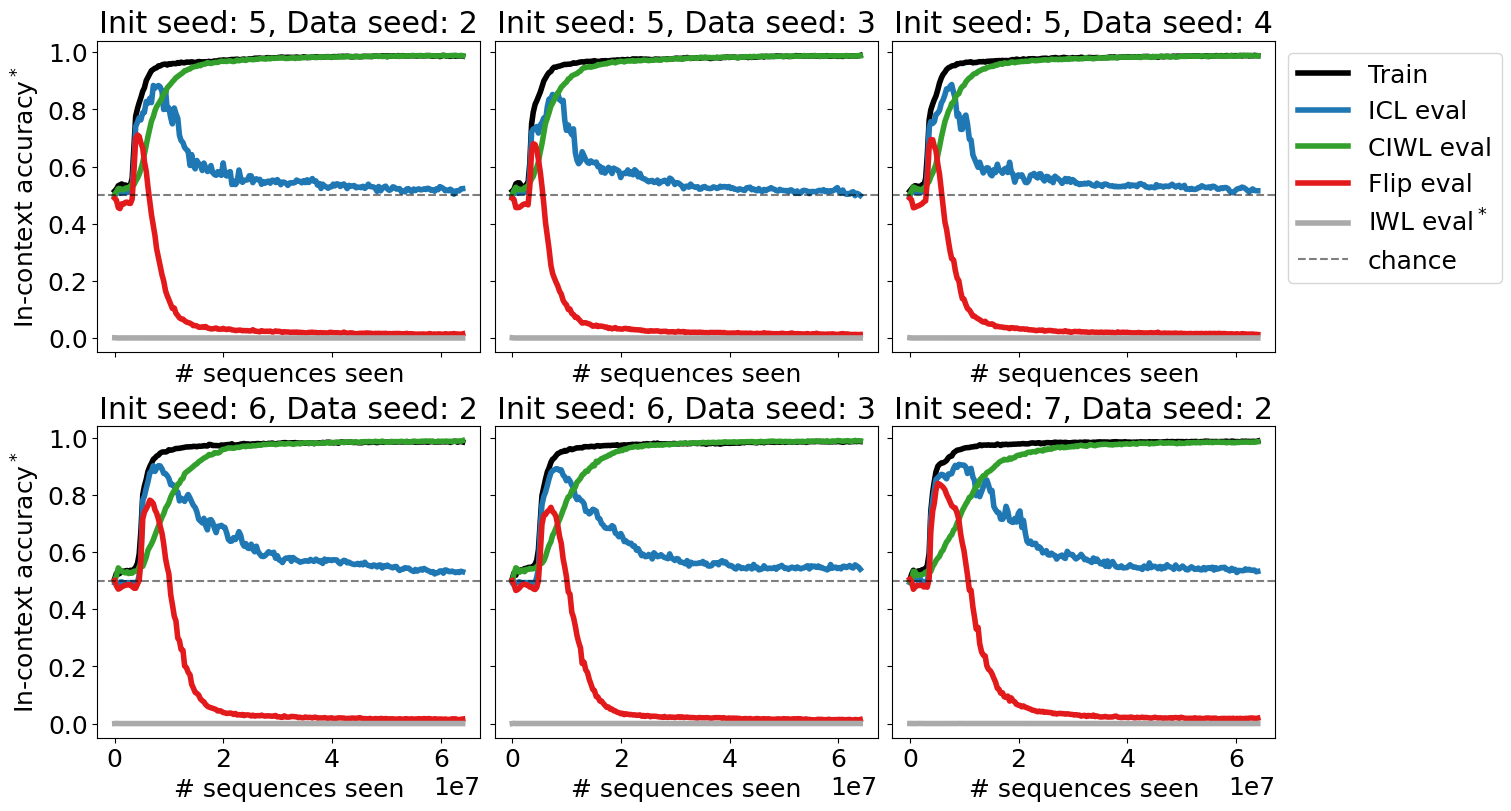

In [6]:
runs = {(5,2): main_run,
        (5,3): 'ts3',
        (5,4): 'ts4',
        (6,2): 'is6',
        (6,3): 'is6_ts3',
        (7,2): 'is7'
       }

matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, constrained_layout=True)
fig.set_size_inches(15, 8)
lw=4

# In context acc is trivially 0 for pure iwl
metric=(lambda name: 'acc' if name == 'pure_iwl' else 'in_context_acc')

to_plot = np.linspace(0, 6.4e7, 200)

for i, name in enumerate(runs):
    f = h5.File(f'{base_folder}/{runs[name]}/log.h5', 'r')
    raw_x = f['eval_iter'][:]
    mask = visualize_runs.get_closest_inds(to_plot, raw_x)
    for e in evaluator_info:
        axs[i//3, i%3].plot(raw_x[mask], np.mean(f[e][metric(e)][mask, :], axis=1), lw=lw, **evaluator_info[e])
    f.close()
    axs[i//3, i%3].axhline(0.5, c='k', ls='--', label='chance', alpha=0.5)
    axs[i//3, i%3].set_title('Init seed: {}, Data seed: {}'.format(*name))
    axs[i//3, i%3].set_xlabel("# sequences seen")

axs[0, -1].legend(bbox_to_anchor=(1, 1), loc='upper left')
axs[0,0].set_ylabel("In-context accuracy$^*$")
axs[1,0].set_ylabel("In-context accuracy$^*$")

fig.savefig(f'{save_folder}/appendix/seeds.pdf')

## Effect of positional embeddings

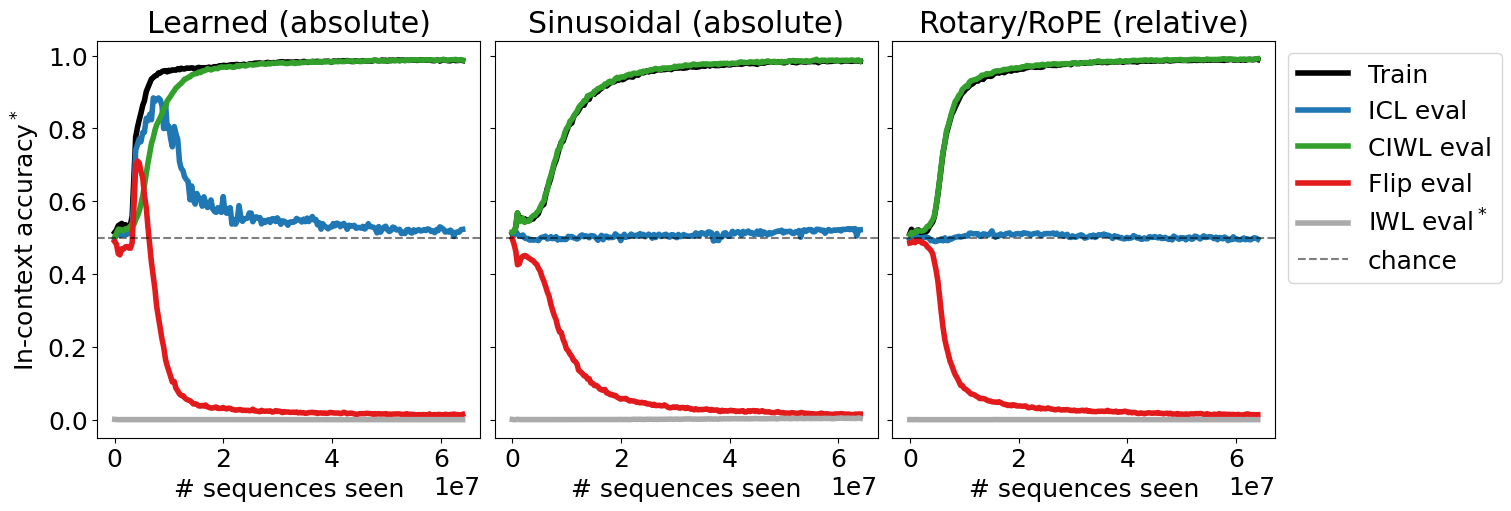

In [7]:
runs = {'Learned (absolute)': main_run, 
        'Sinusoidal (absolute)': 'sinpe', 
        'Rotary/RoPE (relative)': 'rope'}

matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True)
fig.set_size_inches(15, 5)
lw=4

# In context acc is trivially 0 for pure iwl
metric=(lambda name: 'acc' if name == 'pure_iwl' else 'in_context_acc')

to_plot = np.linspace(0, 6.4e7, 200)

for i, name in enumerate(runs):
    f = h5.File(f'{base_folder}/{runs[name]}/log.h5', 'r')
    raw_x = f['eval_iter'][:]
    mask = visualize_runs.get_closest_inds(to_plot, raw_x)
    for e in evaluator_info:
        axs[i].plot(raw_x[mask], np.mean(f[e][metric(e)][mask, :], axis=1), lw=lw, **evaluator_info[e])
    f.close()
    axs[i].axhline(0.5, c='k', ls='--', label='chance', alpha=0.5)
    axs[i].set_title(name)
    axs[i].set_xlabel("# sequences seen")

axs[2].legend(bbox_to_anchor=(1, 1), loc='upper left')
axs[0].set_ylabel("In-context accuracy$^*$")

fig.savefig(f'{save_folder}/appendix/posemb.pdf')

## Effect of data properties

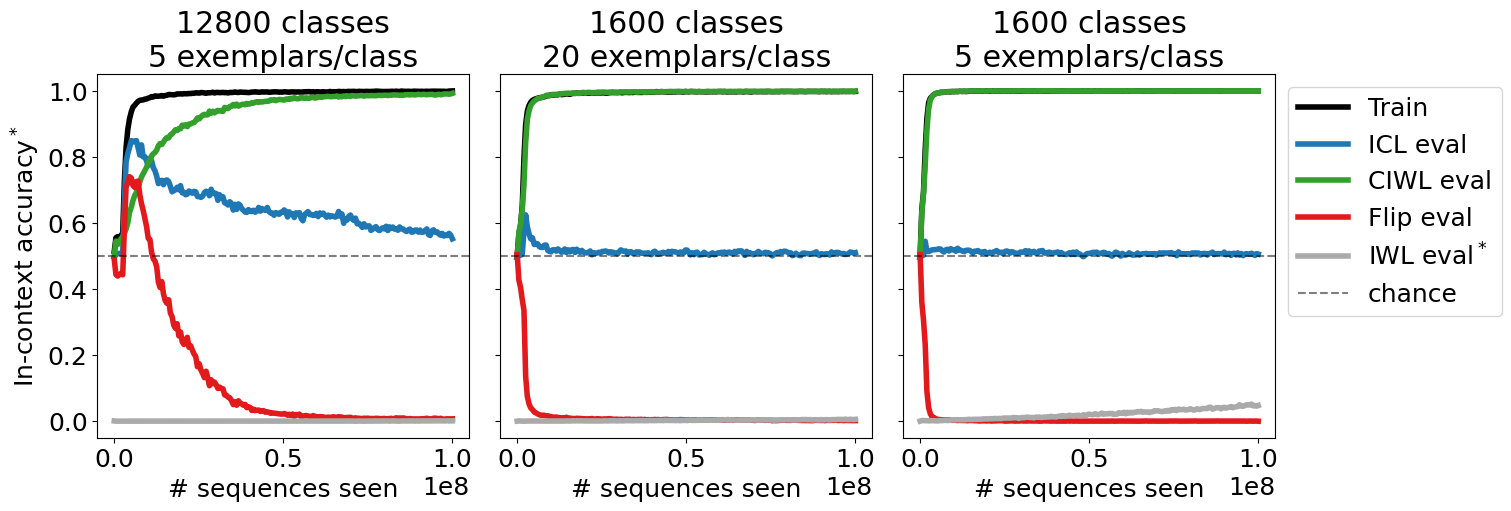

In [8]:
runs = {'12800 classes\n5 exemplars/class': 'c12800_ex5', 
        '1600 classes\n20 exemplars/class': 'c1600_ex20', 
        '1600 classes\n5 exemplars/class': 'c1600_ex5'}

matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True)
fig.set_size_inches(15, 5)
lw=4

# In context acc is trivially 0 for pure iwl
metric=(lambda name: 'acc' if name == 'pure_iwl' else 'in_context_acc')

to_plot = np.linspace(0, 1e8, 200)

for i, name in enumerate(runs):
    f = h5.File(f'{base_folder}/{runs[name]}/log.h5', 'r')
    raw_x = f['eval_iter'][:]
    mask = visualize_runs.get_closest_inds(to_plot, raw_x)
    for e in evaluator_info:
        axs[i].plot(raw_x[mask], np.mean(f[e][metric(e)][mask, :], axis=1), lw=lw, **evaluator_info[e])
    f.close()
    axs[i].axhline(0.5, c='k', ls='--', label='chance', alpha=0.5)
    axs[i].set_title(name)
    axs[i].set_xlabel("# sequences seen")

axs[2].legend(bbox_to_anchor=(1, 1), loc='upper left')
axs[0].set_ylabel("In-context accuracy$^*$")

fig.savefig(f'{save_folder}/appendix/dataprop.pdf')

## Effect of MLPs

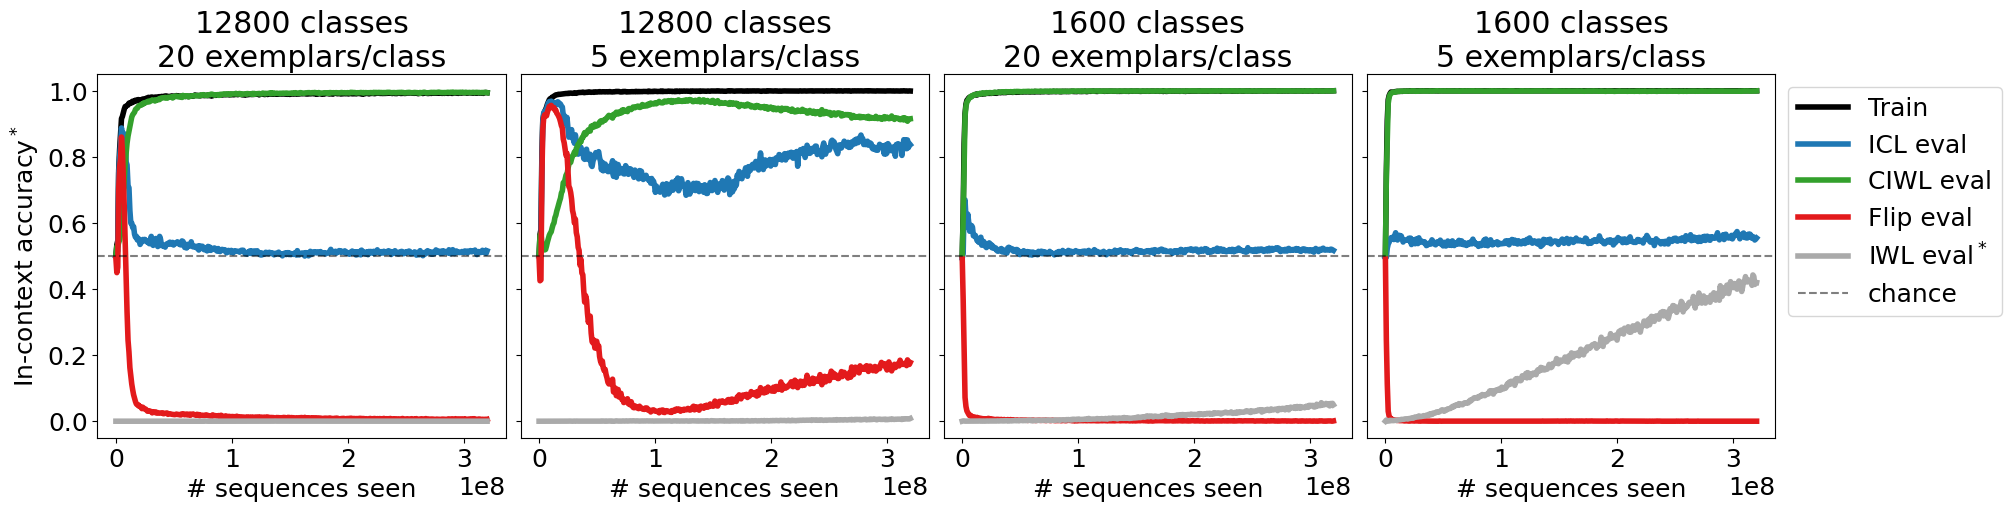

In [9]:
runs = {'12800 classes\n20 exemplars/class': 'mlp',
        '12800 classes\n5 exemplars/class': 'mlp_c12800_ex5', 
        '1600 classes\n20 exemplars/class': 'mlp_c1600_ex20', 
        '1600 classes\n5 exemplars/class': 'mlp_c1600_ex5'}

matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, constrained_layout=True)
fig.set_size_inches(20,5)
lw=4

# In context acc is trivially 0 for pure iwl
metric=(lambda name: 'acc' if name == 'pure_iwl' else 'in_context_acc')

to_plot = np.linspace(0, 3.2e8, 400)

for i, name in enumerate(runs):
    f = h5.File(f'{base_folder}/{runs[name]}/log.h5', 'r')
    raw_x = f['eval_iter'][:]
    mask = visualize_runs.get_closest_inds(to_plot, raw_x)
    for e in evaluator_info:
        axs[i].plot(raw_x[mask], np.mean(f[e][metric(e)][mask, :], axis=1), lw=lw, **evaluator_info[e])
    f.close()
    axs[i].axhline(0.5, c='k', ls='--', label='chance', alpha=0.5)
    axs[i].set_title(name)
    axs[i].set_xlabel("# sequences seen")

axs[-1].legend(bbox_to_anchor=(1, 1), loc='upper left')
axs[0].set_ylabel("In-context accuracy$^*$")

fig.savefig(f'{save_folder}/appendix/mlp.pdf')

# Appendix B: Additional results

## Extended main figure

train_eval 320000000 0.9946
icl 320000000 0.4664
iwl_copy_avail 320000000 0.9948
flip_icl 320000000 0.0054
pure_iwl 320000000 0.0008


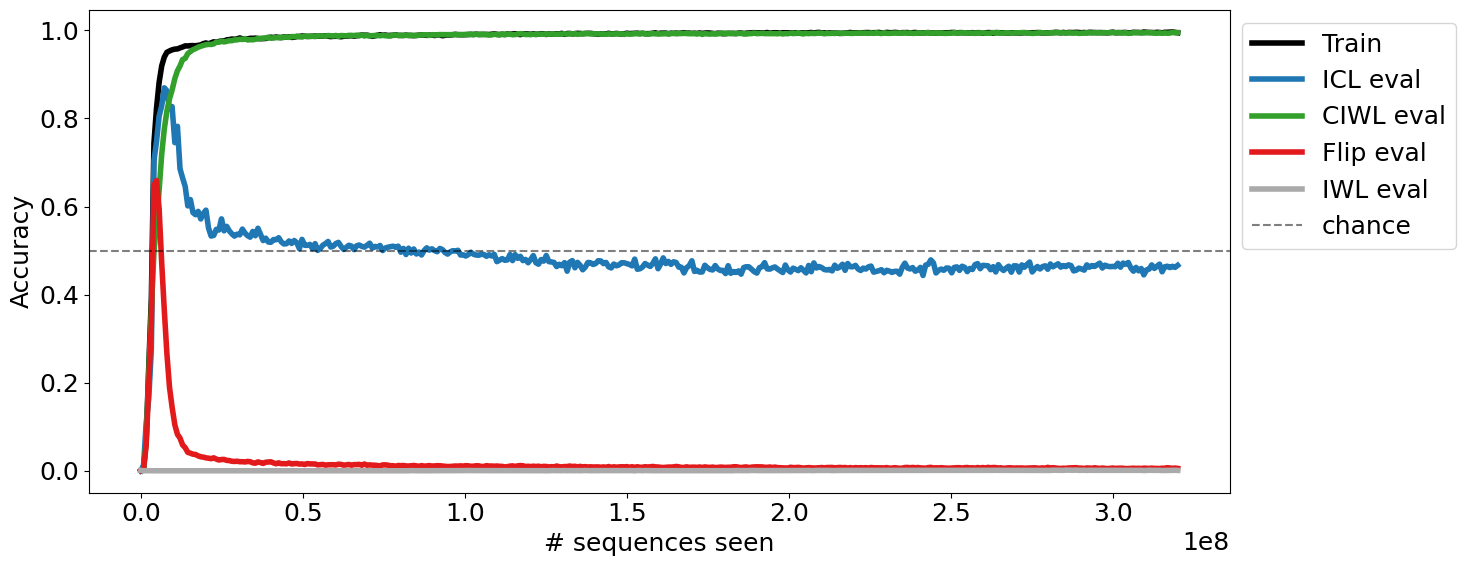

In [10]:
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(15, 6)
lw=4
metric='acc'
evaluator_info['pure_iwl']['label'] = 'IWL eval'

to_plot = np.linspace(0, 3.2e8, 400)

f = h5.File(f'{base_folder}/long_main/log.h5', 'r')
raw_x = f['eval_iter'][:]
to_plot = np.linspace(0, raw_x[-1], 400)
mask = visualize_runs.get_closest_inds(to_plot, raw_x)
for e in evaluator_info:
    axs.plot(raw_x[mask], np.mean(f[e][metric][mask, :], axis=1), lw=lw, **evaluator_info[e])
    print(e, raw_x[-1], np.mean(f[e][metric][-1, :]))
axs.axhline(0.5, c='k', ls='--', label='chance', alpha=0.5)
f.close()

axs.legend(bbox_to_anchor=(1,1), loc='upper left')
axs.set_ylabel("Accuracy")
axs.set_xlabel("# sequences seen")
plt.tight_layout()

fig.savefig(f'{save_folder}/appendix/extended_main.pdf')


## Attention pattern figure

See main notebook, `coopetition_paper_plots.ipynb`.

## Opto boilerplate

We first need to load some boilerplate that'll generally be helpful.

In [12]:
# Get eval data
eval_h5 = h5.File(f'{root_folder}/runs/default_eval/eval_data.h5','r')

eval_data = dict()
for k in eval_h5:
    eval_data[k] = dict()
    for s in eval_h5[k].keys():
        eval_data[k][s] = jnp.array(eval_h5[k][s])
    if 'correct_ind' not in eval_data[k]:
        print("Assigning correct_ind info posthoc", k)
        match_output = eval_data[k]['labels'][:, :-1] == eval_data[k]['labels'][:, -1][:, None]
        eval_data[k]['correct_ind'] = jnp.where(jnp.sum(match_output, axis=1) > 0, jnp.argmax(match_output, axis=1), -1)

Assigning correct_ind info posthoc flip_icl
Assigning correct_ind info posthoc icl
Assigning correct_ind info posthoc iwl_copy_avail
Assigning correct_ind info posthoc pure_iwl
Assigning correct_ind info posthoc train_eval


In [13]:
parser = argparse.ArgumentParser()
opto.add_args_to_parser(parser)
base_opts = parser.parse_args(args=[])
print(base_opts)
batch_size = 1024

Namespace(opto_specific_fn=None, opto_induction_heads=None, opto_induction_head_strength=1.0, opto_match_heads=None, opto_match_head_temperature=0.0, opto_prev_token_heads=None, opto_prev_token_head_strength=1.0, opto_prev_token_only_label=False, opto_disallow_prev_token_heads=None, opto_disallow_prev_token_only_label=False, opto_ablate_heads=None, opto_ablate_embedding=False, opto_perfect_copy_from_head_pattern=None, opto_set_head_temperature=None, opto_final_layer_silence_non_label_attn=None, opto_preserve_patterns=False, opto_preserve_values=False, opto_preserve_queries=False, opto_preserve_keys=False, opto_graft_in_model_ckpt=None, opto_graft_in_model_cfg=None, opto_graft_in_model_till_layer=None, opto_graft_out_model_ckpt=None, opto_graft_out_model_cfg=None, opto_graft_out_model_from_layer=None)


## 1 layer CIWL run

This should be a figure with 4 subpanels. Leftmost will be topline metrics. Then we'll have two plots showing attention patterns. Finally, we'll have the same individiual head ablation result.

In [14]:
single_layer_run = 'depth1'

In [15]:
# Setup model checkpoint load code
opts = main_utils.get_opts_from_json_file(f'{base_folder}/{single_layer_run}/config.json')

# Hardcode data shape to avoid loading in.
model = main_utils.get_model_from_opts(opts, (512, ))
fwd_fn_from_train = opto.make_fn_from_opts(opts)

print("model output shape", model.unembed.weight.shape)
opt_state = main_utils.get_optimizer_from_opts(opts).init(eqx.filter(model, eqx.is_array))

ckpt_fmt = {'iter': -1, 
            'seeds': {'eval_model_seed': jax.random.PRNGKey(0),
                      'train_data_seed': jax.random.PRNGKey(0),
                      'train_model_seed': jax.random.PRNGKey(0)}, 
            'opt_state': opt_state,
            'model': model}

model output shape (12800, 64)


In [16]:
# Get final checkpoint
final_ckpt_fname = '/'.join([base_folder, single_layer_run, 'checkpoints', '{}.eqx'.format(str(int(64e6)).zfill(11))])
single_layer_ckpt = eqx.tree_deserialise_leaves(final_ckpt_fname, ckpt_fmt)

In [17]:
default_fn_with_act = main.make_batched_fn(visualize_runs.make_forward_fn(base_opts, default_fn=fwd_fn_from_train), batch_size)

### Get attention patterns

In [18]:
default_fn_with_act_results = dict()
default_fn_with_act_results['iwl_copy_avail'] = default_fn_with_act(single_layer_ckpt['model'], 
                                                                      eval_data['iwl_copy_avail']['examples'], 
                                                                      eval_data['iwl_copy_avail']['labels'], 
                                                                      key=jax.random.PRNGKey(0))

In [19]:
num_seqs = default_fn_with_act_results['iwl_copy_avail']['activations'].shape[0]

In [20]:
average_attn_per_head_ind2 = jnp.mean(default_fn_with_act_results['iwl_copy_avail']['activations'][(1-eval_data['iwl_copy_avail']['correct_ind']).astype(bool), 1, :, -1, :], axis=0)
average_attn_per_head_ind4 = jnp.mean(default_fn_with_act_results['iwl_copy_avail']['activations'][eval_data['iwl_copy_avail']['correct_ind'].astype(bool), 1, :, -1, :], axis=0)

### Make single head curves to show ST behavior

In [21]:
def make_forward_fn_ic_only(options, default_fn=opto.default_model_fwd_fn):
    '''
    Makes an opto-ified forward_fn that returns just in-context metrics
    '''
    call_fn = opto.make_fn_from_opts(options, default_fn=default_fn)

    def forward_fn(model, x, y, key):
        keys = jax.random.split(key, x.shape[0])
        all_activations = jax.vmap(partial(call_fn, model=model))(x=x, y=y, key=keys)
        query_ce = main.ce(all_activations['out'][:, -1, :], y[:, -1])

        in_context_mask = jnp.sum(jax.nn.one_hot(y[:, :-1], all_activations['out'].shape[-1]), axis=1) > 0
        in_context_pred_y = in_context_mask*all_activations['out'][:, -1, :] - (1-in_context_mask)*1e20
        fsl_loss = main.ce(in_context_pred_y, y[:, -1])
        fsl_output_prob = jnp.einsum('bc,bc->b', 
                                    jax.nn.softmax(in_context_pred_y), 
                                    jax.nn.one_hot(y[:, -1], in_context_pred_y.shape[-1]))
        fsl_output_acc = (jnp.argmax(in_context_pred_y, axis=-1) == y[:,-1])

        return {'in_context_loss': fsl_loss,
                'in_context_prob': fsl_output_prob,
                'in_context_acc': fsl_output_acc,
                'loss': query_ce}

    return eqx.filter_jit(forward_fn)

In [22]:
sl_skip_trigram_copying_fns = dict()
strengths = np.linspace(0, 1, 11)
for h in range(8):
    l0_heads = ['0:{}'.format(head) for head in range(8) if head != h]
    for s in strengths:
        temp_opts = deepcopy(base_opts)
        temp_opts.opto_ablate_heads = l0_heads
        temp_opts.opto_induction_heads = ['0:{}'.format(h)]
        temp_opts.opto_induction_head_strength = s
        temp_opts.opto_ablate_embedding = True
        temp_opts.opto_preserve_patterns = True
        temp_opts.opto_preserve_values = True
        sl_skip_trigram_copying_fns['only_l0h{}_s{:.2f}'.format(h, s)] = main.make_batched_fn(make_forward_fn_ic_only(temp_opts, default_fn=fwd_fn_from_train), batch_size)

Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being u

In [23]:
sl_skip_trigram_copying_results = dict()
for fn_name in tqdm(sl_skip_trigram_copying_fns):
    sl_skip_trigram_copying_results[fn_name] = sl_skip_trigram_copying_fns[fn_name](single_layer_ckpt['model'], 
                                                                                    eval_data['iwl_copy_avail']['examples'], 
                                                                                    eval_data['iwl_copy_avail']['labels'], 
                                                                                    key=jax.random.PRNGKey(0))

  0%|          | 0/88 [00:00<?, ?it/s]

### Make final plot

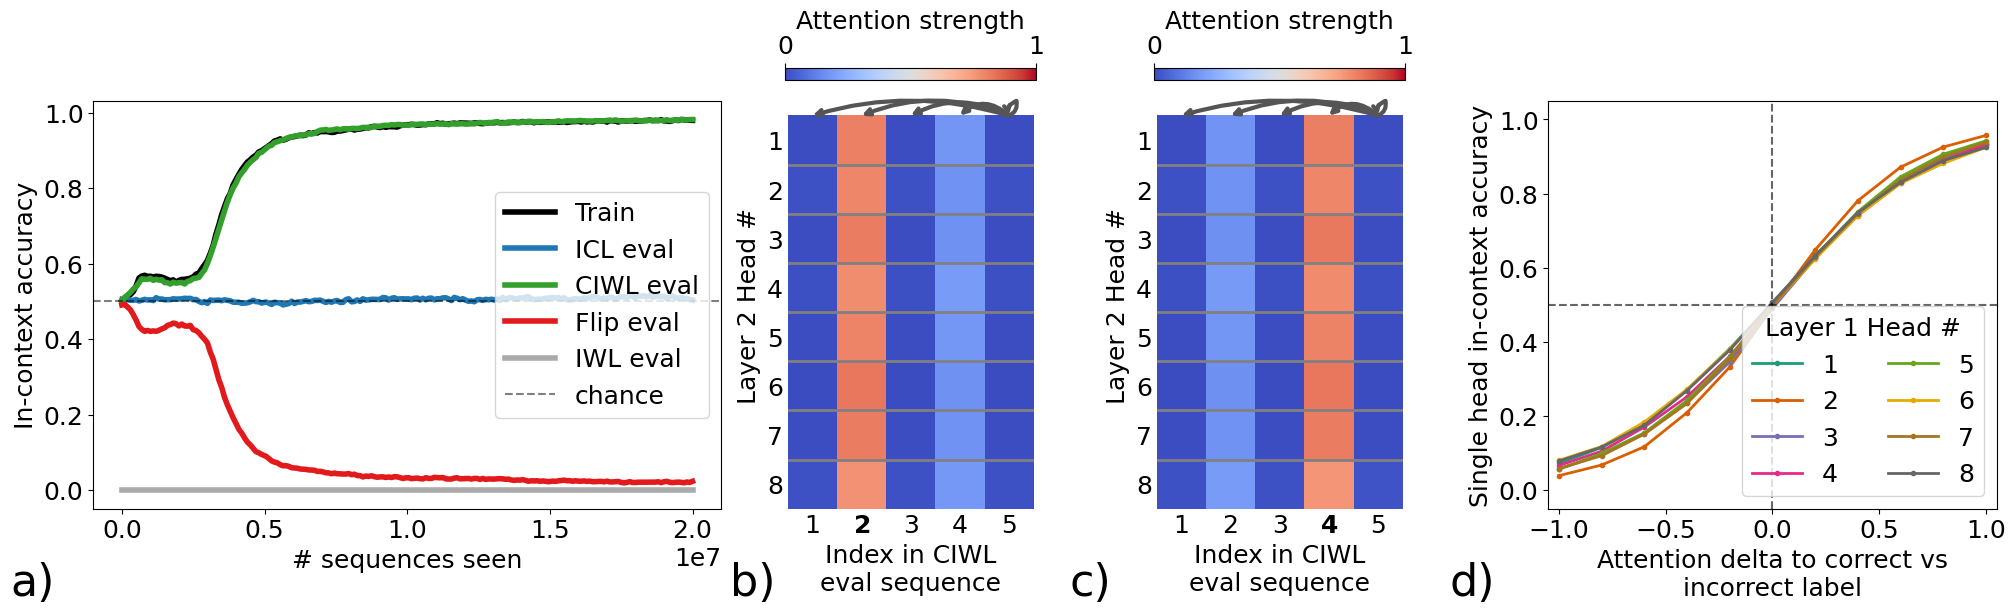

In [24]:
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 4, constrained_layout=True, width_ratios=[0.35, 0.2, 0.2, 0.25])
fig.set_size_inches(20,6)
lw=4

## a

to_plot = np.linspace(0, 2e7, 200)

f = h5.File(f'{base_folder}/{single_layer_run}/log.h5', 'r')
metric='in_context_acc'
raw_x = f['eval_iter'][:]
mask = visualize_runs.get_closest_inds(to_plot, raw_x)
for e in evaluator_info:
    axs[0].plot(raw_x[mask], np.mean(f[e][metric][mask, :], axis=1), lw=lw, **evaluator_info[e])
axs[0].axhline(0.5, c='k', ls='--', label='chance', alpha=0.5)
f.close()

axs[0].legend()
axs[0].set_ylabel("In-context accuracy")
axs[0].set_xlabel("# sequences seen")

## b and c

for ax, attn, bold_ind in zip(axs[1:3], [average_attn_per_head_ind2, average_attn_per_head_ind4], [2,4]):
    im = ax.imshow(attn, cmap='coolwarm', vmin=0, vmax=1)
    
    for l in ['top', 'right', 'bottom', 'left']:
        ax.spines[l].set_visible(False)
    
    for i in range(1,8):
        ax.axhline(i-0.5, linestyle='-', c='gray', lw=2)
    
    arrow_props = dict(
        color='#555555',
        alpha=1,
        linewidth=3
    )
    
    heights = [0.15, 0.2, 0.26, 0.45, 1.5]
    
    # Create arrows from the top of the query column to inserted label column
    for i in range(5):
        con = ConnectionPatch(
            xyA=(4, -0.5),  # Start from top of query column
            xyB=(i, -0.5),     # End at each row of inserted label column
            coordsA='data',
            coordsB='data',
            axesA=ax, axesB=ax,
            connectionstyle='arc3,rad={}'.format(heights[i]),
            arrowstyle='->',
            **arrow_props
        )
        ax.add_artist(con)
    
    
    height = 0.4
    con = ConnectionPatch(
            xyA=(4, -0.5),  # Start from top of query column
            xyB=(4.15, -0.8),     # End at each row of inserted label column
            coordsA='data',
            coordsB='data',
            axesA=ax, axesB=ax,
            connectionstyle='arc3,rad={}'.format(height),
            arrowstyle='-',
            **arrow_props
        )
    ax.add_artist(con)
    
    con = ConnectionPatch(
            xyA=(4.15, -0.8),  # Start from top of query column
            xyB=(4, -0.5),     # End at each row of inserted label column
            coordsA='data',
            coordsB='data',
            axesA=ax, axesB=ax,
            connectionstyle='arc3,rad={}'.format(height),
            arrowstyle='->',
            **arrow_props
        )
    ax.add_artist(con)
    
    fig.colorbar(im, orientation='horizontal', label='Attention strength', 
                 location='top', shrink=0.7, ticks=[0,1], ax=ax)

    ax.tick_params(axis='both', length=0)
    ax.set_yticks(range(8), range(1, 9))
    ax.set_ylabel('Layer 2 Head #')
    ax.set_ylim(7.5, -0.8)
    ax.set_xticks(range(5), [( (r'$\bf{'+str(bold_ind)+r'}$') if i == bold_ind else str(i)) for i in range(1,6)])
    ax.set_xlabel('Index in CIWL\neval sequence')

## d

cmap = plt.get_cmap('Dark2')
for h in range(8):
    axs[3].plot(strengths*2-1, [jnp.mean(sl_skip_trigram_copying_results['only_l0h{}_s{:.2f}'.format(h, s)]['in_context_acc']) 
                             for s in strengths],
             marker='.', lw=2,
             c=cmap(h), label=h+1)

axs[3].legend(loc='lower right', title='Layer 1 Head #', ncol=2)
axs[3].axhline(0.5, c='k', ls='--', alpha=0.6)
axs[3].axvline(0, c='k', ls='--', alpha=0.6)
axs[3].set_xlim(-1.05, 1.05)
axs[3].set_ylim(-0.05, 1.05)
axs[3].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs[3].set_ylabel('Single head in-context accuracy')
axs[3].set_xlabel('Attention delta to correct vs\nincorrect label')

fig.text(0, 0, 'a)', ha='left', va='bottom', fontsize=32)
fig.text(0.36, 0, 'b)', ha='left', va='bottom', fontsize=32)
fig.text(0.53, 0, 'c)', ha='left', va='bottom', fontsize=32)
fig.text(0.72, 0, 'd)', ha='left', va='bottom', fontsize=32)

fig.savefig(f'{save_folder}/appendix/single_layer_ciwl.pdf')

## Layer 1 attention patterns in standard run

We'll plot average attention from labels to previous tokens over the course of training, vs average attention to self. We have to do this per head (since there is some diversity).

To do this, we can grab numbers from `visualize_runs`:

In [25]:
vis_end = 20000000

In [26]:
parser = visualize_runs.create_parser()
opto.add_args_to_parser(parser)
meta_opts = parser.parse_args(['--base_folder', '/nfs/gatsbystor/asingh/coopetition/runs',
                                 '--plots', 'all_token_layer_attention_over_time',
                                 '--run_folder', main_run, '--data_mode', 'eval',
                                 '--data_file', f'{root_folder}/runs/default_eval/eval_data.h5',
                                 '--eval_subsets', *list(evaluator_info),
                                 '--only_plot_avg', '--metric_range', '0', '1',
                                 '--plot_range', '0', str(vis_end)
                              ])
all_data = visualize_runs.make_data(meta_opts, None)

Found these subsets in file prefix : ['flip_icl', 'icl', 'iwl_copy_avail', 'pure_iwl', 'train_eval']
Loaded in all eval data (25000, 3, 512)


In [27]:
per_subset_results = dict()
for eval_subset in list(evaluator_info):
    temp_meta_opts = deepcopy(meta_opts)
    temp_meta_opts.eval_subsets = [eval_subset]
    subset_data = visualize_runs.make_data(temp_meta_opts, None)
    per_subset_results[eval_subset] = {plot_type: dict() for plot_type in temp_meta_opts.plots}
    visualize_runs.populate_plot_info(per_subset_results[eval_subset], temp_meta_opts, '/'.join([temp_meta_opts.base_folder, temp_meta_opts.run_folder[0]]), subset_data)

Found these subsets in file prefix : ['flip_icl', 'icl', 'iwl_copy_avail', 'pure_iwl', 'train_eval']
Loaded in all eval data (5000, 3, 512)
model output shape (12800, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:10<00:00, 36.51it/s]


Found these subsets in file prefix : ['flip_icl', 'icl', 'iwl_copy_avail', 'pure_iwl', 'train_eval']
Loaded in all eval data (5000, 3, 512)
model output shape (12800, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:10<00:00, 40.03it/s]


Found these subsets in file prefix : ['flip_icl', 'icl', 'iwl_copy_avail', 'pure_iwl', 'train_eval']
Loaded in all eval data (5000, 3, 512)
model output shape (12800, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:09<00:00, 40.99it/s]


Found these subsets in file prefix : ['flip_icl', 'icl', 'iwl_copy_avail', 'pure_iwl', 'train_eval']
Loaded in all eval data (5000, 3, 512)
model output shape (12800, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:10<00:00, 37.58it/s]


Found these subsets in file prefix : ['flip_icl', 'icl', 'iwl_copy_avail', 'pure_iwl', 'train_eval']
Loaded in all eval data (5000, 3, 512)
model output shape (12800, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:09<00:00, 42.73it/s]


In [28]:
per_subset_results.keys()

dict_keys(['train_eval', 'icl', 'iwl_copy_avail', 'flip_icl', 'pure_iwl'])

/tmp/ipykernel_3157097/2573555468.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Dark2')(np.arange(8))


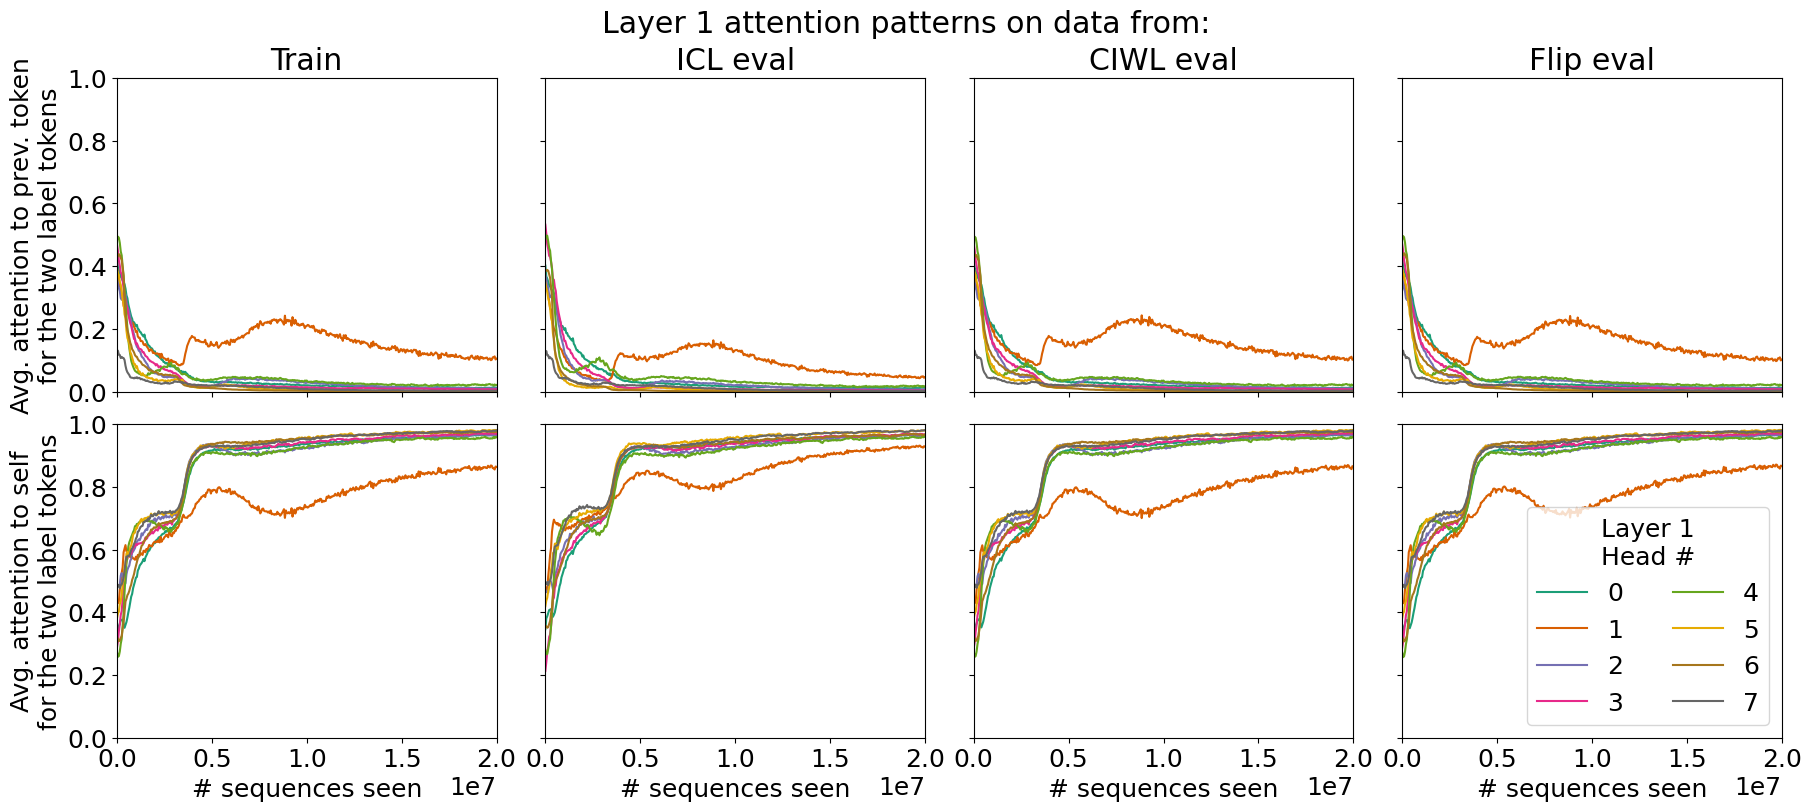

In [29]:
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(2,4,sharex=True, sharey=True, constrained_layout=True)
fig.set_size_inches(18,8)

colors = plt.cm.get_cmap('Dark2')(np.arange(8))

for i, subset in enumerate(per_subset_results):
    if subset == 'pure_iwl':
        continue
    pt_scores = []
    self_scores = []
    for k in ['activations_ind0', 'activations_ind1']:
        act = jnp.stack(per_subset_results[subset]['all_token_layer_attention_over_time'][k])
        pt_scores.append(jnp.mean(act[:, 0, :, [1,3], [0,2]], axis=0).T)
        self_scores.append(jnp.mean(act[:, 0, :, [1,3], [1,3]], axis=0).T)
    # Not using plot_utils.make_line_collection since not sure how to add legend
    x = per_subset_results[subset]['all_token_layer_attention_over_time']['iters']
    y0s = jnp.mean(jnp.array(pt_scores), axis=0)
    y1s = jnp.mean(jnp.array(self_scores), axis=0)
    for h in range(8):
        axs[0,i].plot(x, y0s[h,:], label=h, c=colors[h])
        axs[1,i].plot(x, y1s[h,:], label=h, c=colors[h])
    axs[0,i].set_title(evaluator_info[subset]['label'])
    axs[1,i].set_xlabel('# sequences seen')

axs[-1, -1].legend(title='Layer 1\nHead #', ncol=2)#, bbox_to_anchor=(0.8,1), ncol=2, loc='upper left')
axs[0,0].set_xlim(0, vis_end)
axs[0,0].set_ylim(0, 1)
axs[0,0].set_ylabel('Avg. attention to prev. token\nfor the two label tokens')
axs[1,0].set_ylabel('Avg. attention to self\nfor the two label tokens')
fig.suptitle('Layer 1 attention patterns on data from:')

fig.savefig(f'{save_folder}/appendix/avg_pt_attn_patterns.pdf')

## Appendix B.1 Networks barely do pure IWL

In [30]:
# Setup model checkpoint load code
opts = main_utils.get_opts_from_json_file(f'{base_folder}/{main_run}/config.json')

# Hardcode data shape to avoid loading in.
model = main_utils.get_model_from_opts(opts, (512, ))
fwd_fn_from_train = opto.make_fn_from_opts(opts)

print("model output shape", model.unembed.weight.shape)
opt_state = main_utils.get_optimizer_from_opts(opts).init(eqx.filter(model, eqx.is_array))

ckpt_fmt = {'iter': -1, 
            'seeds': {'eval_model_seed': jax.random.PRNGKey(0),
                      'train_data_seed': jax.random.PRNGKey(0),
                      'train_model_seed': jax.random.PRNGKey(0)}, 
            'opt_state': opt_state,
            'model': model}

model output shape (12800, 64)


In [31]:
# Get final checkpoint
final_ckpt_fname = '/'.join([base_folder, main_run, 'checkpoints', '{}.eqx'.format(str(int(64e6)).zfill(11))])
final_ckpt = eqx.tree_deserialise_leaves(final_ckpt_fname, ckpt_fmt)

In [32]:
temp_opts = deepcopy(base_opts)
default_fn = main.make_batched_fn(make_forward_fn_ic_only(temp_opts, default_fn=fwd_fn_from_train), batch_size)

In [33]:
temp_opts = deepcopy(base_opts)
# ablate all heads
temp_opts.opto_ablate_heads = ['0:{}'.format(head) for head in range(8)] + ['1:{}'.format(head) for head in range(8)]
only_embunemb_fn = main.make_batched_fn(make_forward_fn_ic_only(temp_opts, default_fn=fwd_fn_from_train), batch_size)

temp_opts = deepcopy(base_opts)
# ablate emb
temp_opts.opto_ablate_embedding = True
# Make sure rest of network is fine
temp_opts.opto_preserve_patterns = True
temp_opts.opto_preserve_values = True
no_embunemb_fn = main.make_batched_fn(make_forward_fn_ic_only(temp_opts, default_fn=fwd_fn_from_train), batch_size)

Opto being used...
Opto being used...


In [34]:
iwl_ablation_results = dict()
for name, fn in zip(['default', 'only_embunemb', 'no_embunemb'], [default_fn, only_embunemb_fn, no_embunemb_fn]):
    for e in ['train_eval', 'iwl_copy_avail', 'flip_icl', 'pure_iwl']:
        iwl_ablation_results.setdefault(name, dict())[e] = fn(final_ckpt['model'], 
                                                                    eval_data[e]['examples'], 
                                                                    eval_data[e]['labels'], 
                                                                    key=jax.random.PRNGKey(0))

In [35]:
for e in iwl_ablation_results[name]:
    for metric in ['in_context_acc']:
        for name in iwl_ablation_results:
            print(name, e, metric, jnp.mean(iwl_ablation_results[name][e][metric]))

default train_eval in_context_acc 0.9862
only_embunemb train_eval in_context_acc 0.6268
no_embunemb train_eval in_context_acc 0.96739995
default iwl_copy_avail in_context_acc 0.9874
only_embunemb iwl_copy_avail in_context_acc 0.6242
no_embunemb iwl_copy_avail in_context_acc 0.9672
default flip_icl in_context_acc 0.014599999
only_embunemb flip_icl in_context_acc 0.3752
no_embunemb flip_icl in_context_acc 0.033999998
default pure_iwl in_context_acc 0.0
only_embunemb pure_iwl in_context_acc 0.0
no_embunemb pure_iwl in_context_acc 0.0


## Appendix B.2: Layer 2 heads may act in superposition

This plot will have 3 subfigures:

1. We'll show that two heads, on the same set of points, have very different attention patterns relative to each other.
2. We'll show that for a _single active head_, decreasing the _temperature_ of the attention enhances performance.
3. Doing this when all heads are present however, doesn't help as much.

For the latter two plots, I think we may want to use probability (as that corresponds better to loss). We'll compute all plots here on train data, to prevent any OOD confounds.

### Subfigure 1: attention of two heads, same points

In [36]:
default_end_out = default_fn_with_act(final_ckpt['model'], 
                                          eval_data['train_eval']['examples'], 
                                          eval_data['train_eval']['labels'], 
                                          key=jax.random.PRNGKey(0))

In [37]:
correct_scores = default_end_out['activations'][jnp.arange(default_end_out['activations'].shape[0]), 1, :, -1, eval_data['train_eval']['correct_ind']*2+1]
incorrect_scores = default_end_out['activations'][jnp.arange(default_end_out['activations'].shape[0]), 1, :, -1, (1-eval_data['train_eval']['correct_ind'])*2+1]

In [38]:
induction_strength = correct_scores - incorrect_scores

### Subfigure 2: Single L2 head active, sweep temp

In [39]:
temperatures = [0.1, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.92, 0.94, 0.96, 0.98, 1.02, 1.04, 1.06, 1.08, 1.1, 1.15, 1.2, 1.25, 2, 4, 8]

In [40]:
only_one_temp_fns = dict()

In [41]:
for h in range(8):
    for t in temperatures:
        l1_heads = ['1:{}'.format(head) for head in range(8) if head != h]
        temp_opts = deepcopy(base_opts)
        temp_opts.opto_ablate_heads = l1_heads
        temp_opts.opto_final_layer_silence_non_label_attn = [h]
        temp_opts.opto_set_head_temperature = ['1:{}:{}'.format(h, t)]
        only_one_temp_fns[(h,t)] = main.make_batched_fn(make_forward_fn_ic_only(temp_opts, default_fn=fwd_fn_from_train), batch_size)

Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being u

In [42]:
only_one_temp_sweep = dict()
for h in range(8):
    print(h)
    only_one_temp_sweep[h] = []
    for t in temperatures:
        print(t)
        only_one_temp_sweep[h].append(jnp.mean(only_one_temp_fns[(h,t)](final_ckpt['model'], 
                                                                          eval_data['train_eval']['examples'], 
                                                                          eval_data['train_eval']['labels'], 
                                                                          key=jax.random.PRNGKey(0))['in_context_prob']
                                              )
                                     )

0
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
1
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
2
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
3
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
4
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
5
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
6
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
7
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8


### Subfigure 2: Single L2 head active, sweep temp

In [43]:
temp_fns = dict()

In [44]:
for h in range(8):
    for t in temperatures:
        temp_opts = deepcopy(base_opts)
        temp_opts.opto_final_layer_silence_non_label_attn = list(range(8))
        temp_opts.opto_set_head_temperature = ['1:{}:{}'.format(h, t)]
        temp_fns[(h,t)] = main.make_batched_fn(make_forward_fn_ic_only(temp_opts, default_fn=fwd_fn_from_train), batch_size)

Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being u

In [45]:
temp_sweep = dict()
for h in range(8):
    print(h)
    temp_sweep[h] = []
    for t in temperatures:
        print(t)
        temp_sweep[h].append(jnp.mean(temp_fns[(h,t)](final_ckpt['model'], 
                                                      eval_data['train_eval']['examples'], 
                                                      eval_data['train_eval']['labels'], 
                                                      key=jax.random.PRNGKey(0))['in_context_prob']
                                              )
                                     )

0
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
1
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
2
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
3
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
4
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
5
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
6
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8
7
0.1
0.25
0.5
0.75
0.8
0.85
0.9
0.92
0.94
0.96
0.98
1.02
1.04
1.06
1.08
1.1
1.15
1.2
1.25
2
4
8


### Make full plot

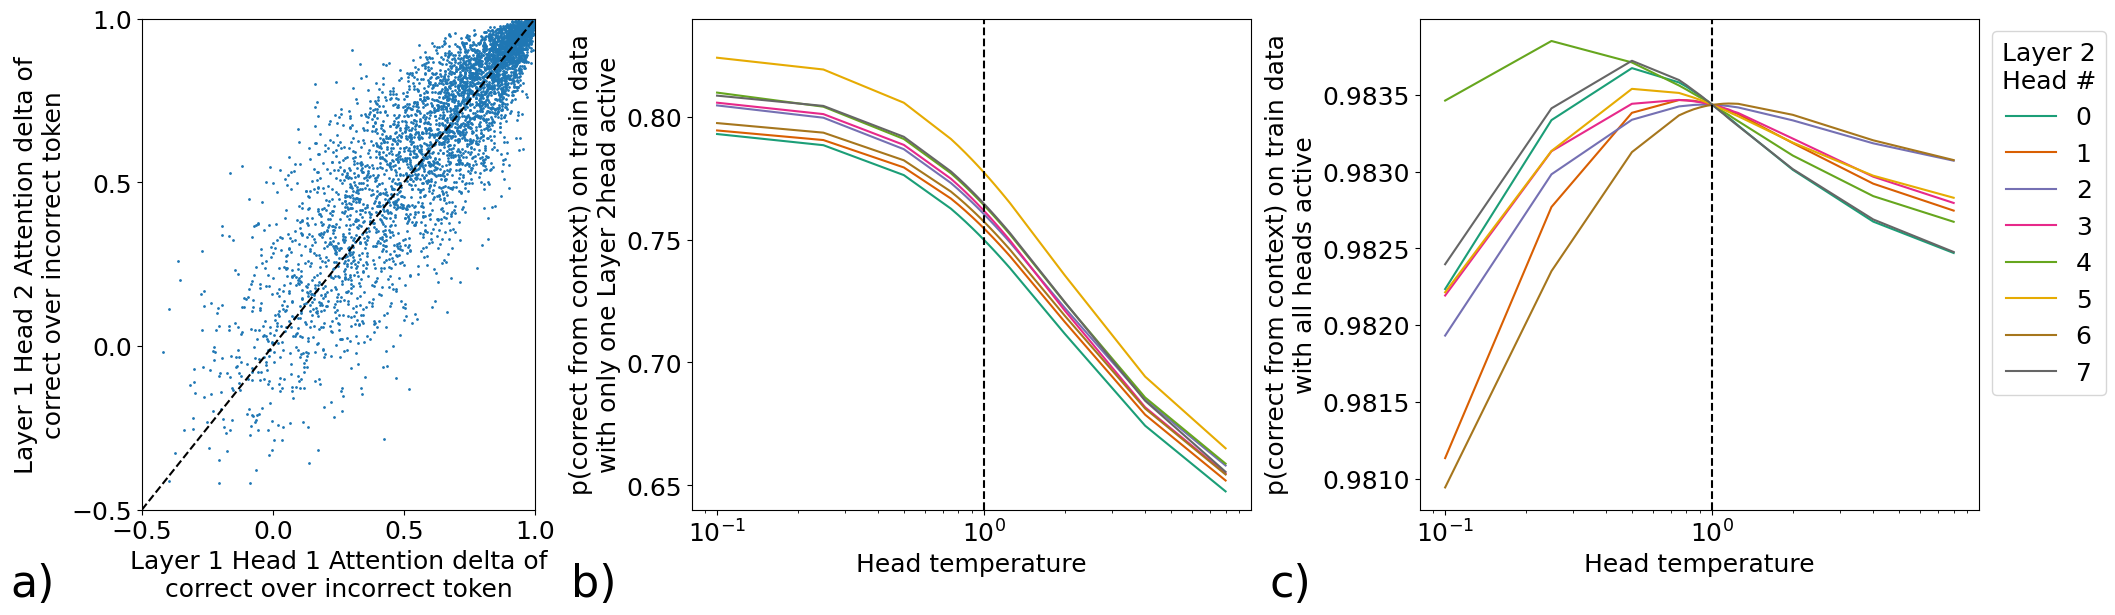

In [46]:
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 3, constrained_layout=True, width_ratios=[0.26, 0.37, 0.37])
fig.set_size_inches(21,6)
lw=4

## a

axs[0].scatter(induction_strength[:, 0], induction_strength[:, 1], marker='.', s=4)
axs[0].set_xlabel('Layer 1 Head 1 Attention delta of\ncorrect over incorrect token')
axs[0].set_ylabel('Layer 1 Head 2 Attention delta of\ncorrect over incorrect token')
axs[0].set_xlim(-0.5,1)
axs[0].set_ylim(-0.5,1)
axs[0].plot([-0.5, 1], [-0.5, 1], ls='--', c='k')
axs[0].set_xticks([-0.5, 0, 0.5, 1])
axs[0].set_yticks([-0.5, 0, 0.5, 1])

## b

for h in only_one_temp_sweep:
    axs[1].plot(temperatures, only_one_temp_sweep[h], label=h, c=colors[h])
axs[1].set_xscale('log')
axs[1].set_ylim(0.64, 0.84)
axs[1].set_yticks([0.65, 0.7, 0.75, 0.8])
axs[1].axvline(1, ls='--', c='k')
axs[1].set_xlabel('Head temperature')
axs[1].set_ylabel('p(correct from context) on train data\nwith only one Layer 2head active')

## c

for h in only_one_temp_sweep:
    axs[2].plot(temperatures, temp_sweep[h], label=h, c=colors[h])
axs[2].set_xscale('log')
# axs[2].set_ylim(0.64, 0.84)
# axs[2].set_yticks([0.65, 0.7, 0.75, 0.8])
axs[2].axvline(1, ls='--', c='k')
axs[2].set_xlabel('Head temperature')
axs[2].set_ylabel('p(correct from context) on train data\nwith all heads active')
axs[2].legend(bbox_to_anchor=(1,1), title='Layer 2\nHead #')


fig.text(0, 0, 'a)', ha='left', va='bottom', fontsize=32)
fig.text(0.267, 0, 'b)', ha='left', va='bottom', fontsize=32)
fig.text(0.60, 0, 'c)', ha='left', va='bottom', fontsize=32)

fig.savefig(f'{save_folder}/appendix/superposition.pdf')

# Appendix C: Toy model

In [48]:
toy_model_results = dict()

toy_model_results['loss'] = coopetition_model_solver.make_4share2_loss_fn(alpha=0.1, mu1=0.1)
toy_model_results['setups'] = dict()
toy_model_results['results'] = dict()

In [49]:
for seed in range(12):
    toy_model_results['setups'][seed] = coopetition_model_solver.make_rank_1_vecs_setup(**toy_model_results['loss'], dims=[20,20,20,160], seed=seed)
    toy_model_results['results'][seed] = coopetition_model_solver.train(toy_model_results['setups'][seed], max_iters=16000, thresh=1e-6)

  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 8834


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 14482


  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 6138


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 9306


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 5104


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 8146


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 9620


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 4244


  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 6745


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 4603


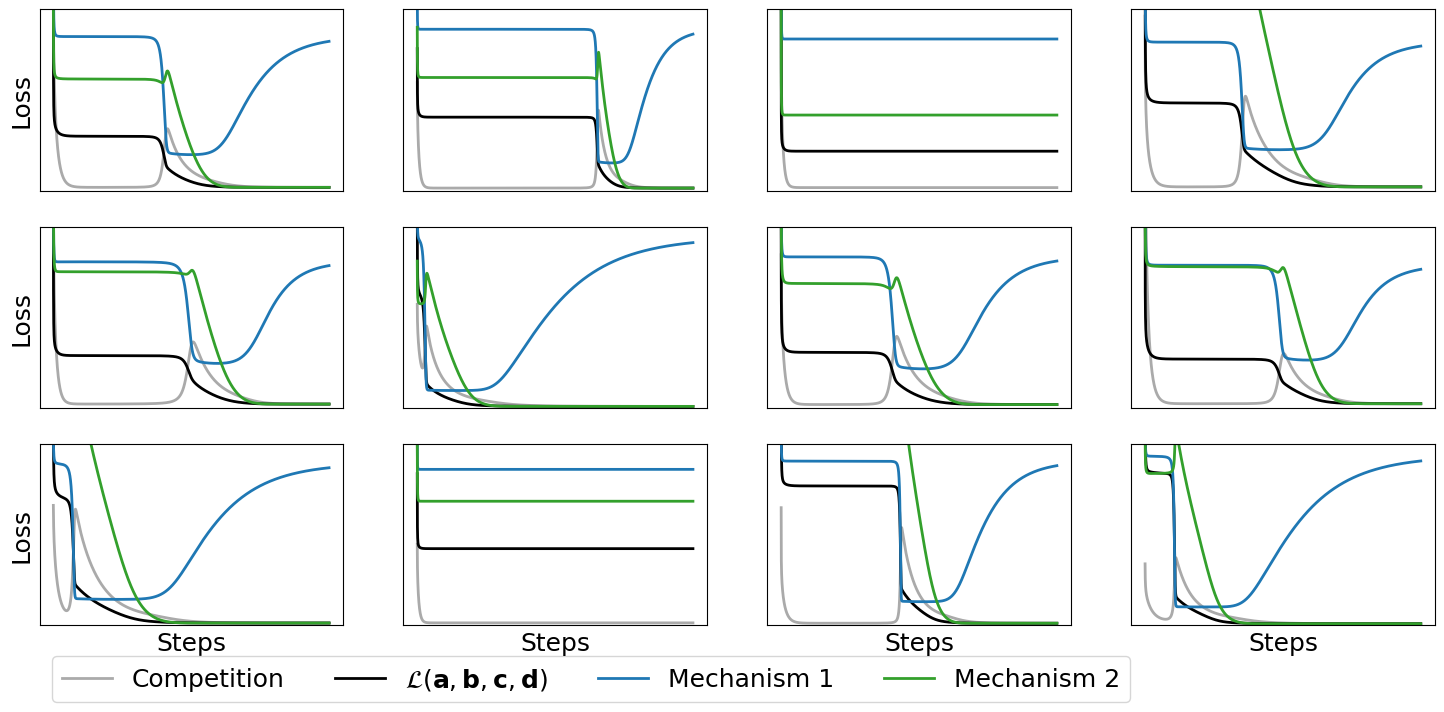

In [50]:
fig, axs = plt.subplots(3,4)
fig.set_size_inches(18,8)
lw=2

mechanism_info = {'Train loss': {'offset': 0, 'c': evaluator_info['train_eval']['c'], 
                                 # 'label': r'$\bf{\big{\mathcal{L}}(a, b, c, d)}$'},
                                 'label': r'$\mathcal{L}(\mathbf{a}, \mathbf{b}, \mathbf{c}, \mathbf{d})$'},
                  'Mechanism 1 loss': {'offset': 0.1, 'c': evaluator_info['icl']['c'], 'label': 'Mechanism 1'},
                  'Mechanism 2 loss': {'offset': 0, 'c': evaluator_info['iwl_copy_avail']['c'], 'label': 'Mechanism 2'},
                  'Cost': {'offset': 0, 'c': evaluator_info['pure_iwl']['c'], 'label': 'Competition'}
                 }

for seed in range(12):
    ax = axs[seed // 4, seed % 4]
    lim = 0
    for l in ['Cost', 'Train loss', 'Mechanism 1 loss', 'Mechanism 2 loss']:
        ax.plot(np.array(toy_model_results['results'][seed][l]) + mechanism_info[l]['offset'], 
                label=mechanism_info[l]['label'], c = mechanism_info[l]['c'], lw=lw)
        lim = max(lim, toy_model_results['results'][seed][l][-1])
    ax.set_ylim(-0.01,lim+0.2)
    ax.set_xticks([])
    ax.set_yticks([])

for i in range(3):
    axs[i,0].set_ylabel('Loss')
for j in range(4):
    axs[-1,j].set_xlabel('Steps')
axs[-1,0].legend(bbox_to_anchor=(0,-0.1), loc='upper left', ncol=4)
fig.savefig(f'{save_folder}/appendix/toymodel.pdf')

In [51]:
toy_model0_results = dict()

toy_model0_results['loss'] = coopetition_model_solver.make_4share2_loss_fn(alpha=0.1, mu1=0)
toy_model0_results['setups'] = dict()
toy_model0_results['results'] = dict()

In [52]:
for seed in range(12):
    toy_model0_results['setups'][seed] = coopetition_model_solver.make_rank_1_vecs_setup(**toy_model0_results['loss'], dims=[20,20,20,160], seed=seed)
    toy_model0_results['results'][seed] = coopetition_model_solver.train(toy_model0_results['setups'][seed], max_iters=16000, thresh=1e-3)

  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 8661


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 15787


  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 8291


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 9931


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 5258


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 9247


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 10080


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 7792


  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 9791


  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 5088


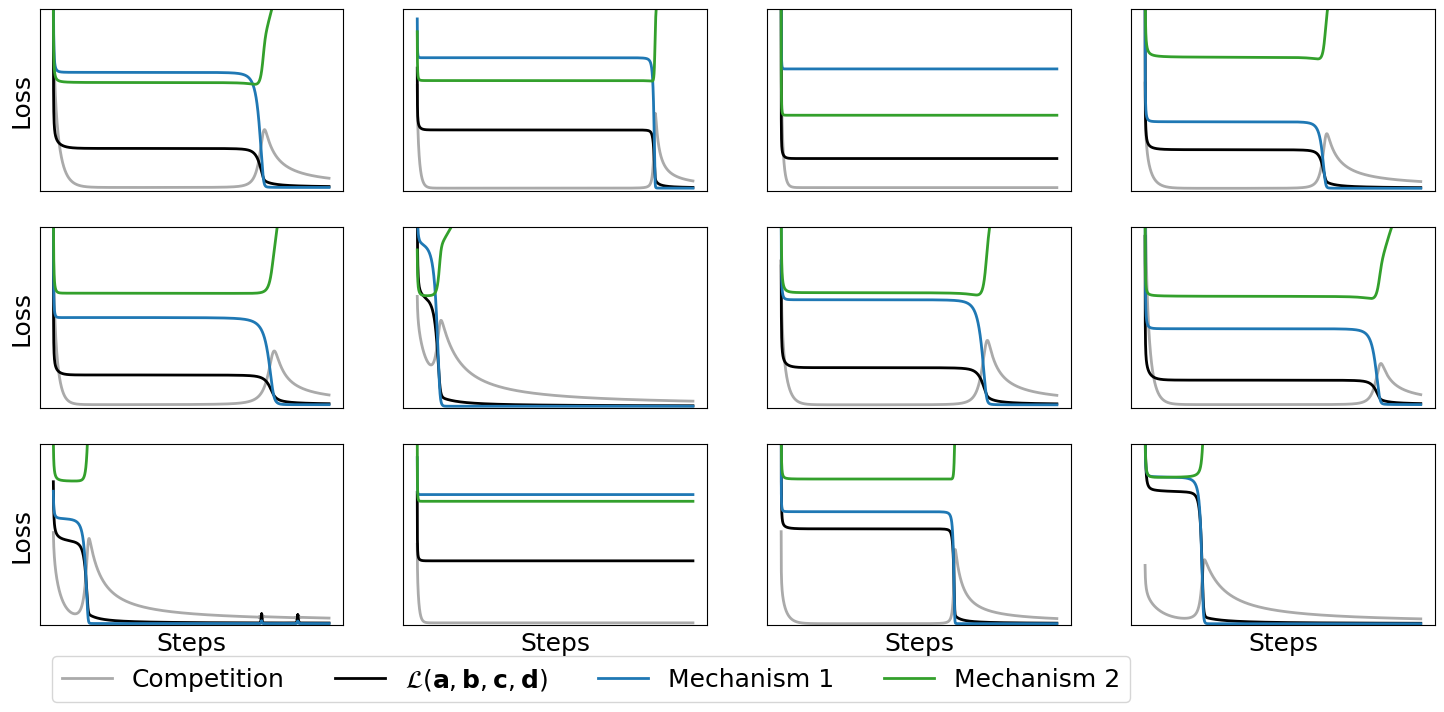

In [53]:
fig, axs = plt.subplots(3,4)
fig.set_size_inches(18,8)
lw=2

mechanism_info = {'Train loss': {'offset': 0, 'c': evaluator_info['train_eval']['c'], 
                                 'label': r'$\mathcal{L}(\mathbf{a}, \mathbf{b}, \mathbf{c}, \mathbf{d})$'},
                  'Mechanism 1 loss': {'offset': 0, 'c': evaluator_info['icl']['c'], 'label': 'Mechanism 1'},
                  'Mechanism 2 loss': {'offset': 0, 'c': evaluator_info['iwl_copy_avail']['c'], 'label': 'Mechanism 2'},
                  'Cost': {'offset': 0, 'c': evaluator_info['pure_iwl']['c'], 'label': 'Competition'}
                 }

for seed in range(12):
    ax = axs[seed // 4, seed % 4]
    lim = 0
    # We limit the plot since Mech 2 loss somewhat diverges leading to instability at fixed LR later in dynamics
    mask = np.array(toy_model0_results['results'][seed]['Train loss']) < 3e-3
    max_ind = np.argmax(mask) if np.any(mask) else -1
    for l in ['Cost', 'Train loss', 'Mechanism 1 loss', 'Mechanism 2 loss']:
        y = np.array(toy_model0_results['results'][seed][l])
        ax.plot(y[:max_ind] + mechanism_info[l]['offset'], 
                label=mechanism_info[l]['label'], c = mechanism_info[l]['c'], lw=lw)
        lim = max(lim, toy_model0_results['results'][seed][l][100])
    ax.set_ylim(-0.01,lim+0.2)
    ax.set_xticks([])
    ax.set_yticks([])

for i in range(3):
    axs[i,0].set_ylabel('Loss')
for j in range(4):
    axs[-1,j].set_xlabel('Steps')
axs[-1,0].legend(bbox_to_anchor=(0,-0.1), loc='upper left', ncol=4)
fig.savefig(f'{save_folder}/appendix/toymodel0.pdf')

# Appendix D: Rejected hypotheses

In [54]:
lighter_colors = {'k': '#808080', '#1f78b4': '#a6cee3', '#33a02c': '#b2df8a', '#e31a1c': '#fb9a99'}

In [55]:
evaluator_info

{'train_eval': {'label': 'Train', 'c': 'k'},
 'icl': {'label': 'ICL eval', 'c': '#1f78b4'},
 'iwl_copy_avail': {'label': 'CIWL eval', 'c': '#33a02c'},
 'flip_icl': {'label': 'Flip eval', 'c': '#e31a1c'},
 'pure_iwl': {'label': 'IWL eval', 'c': '#AAAAAA'}}

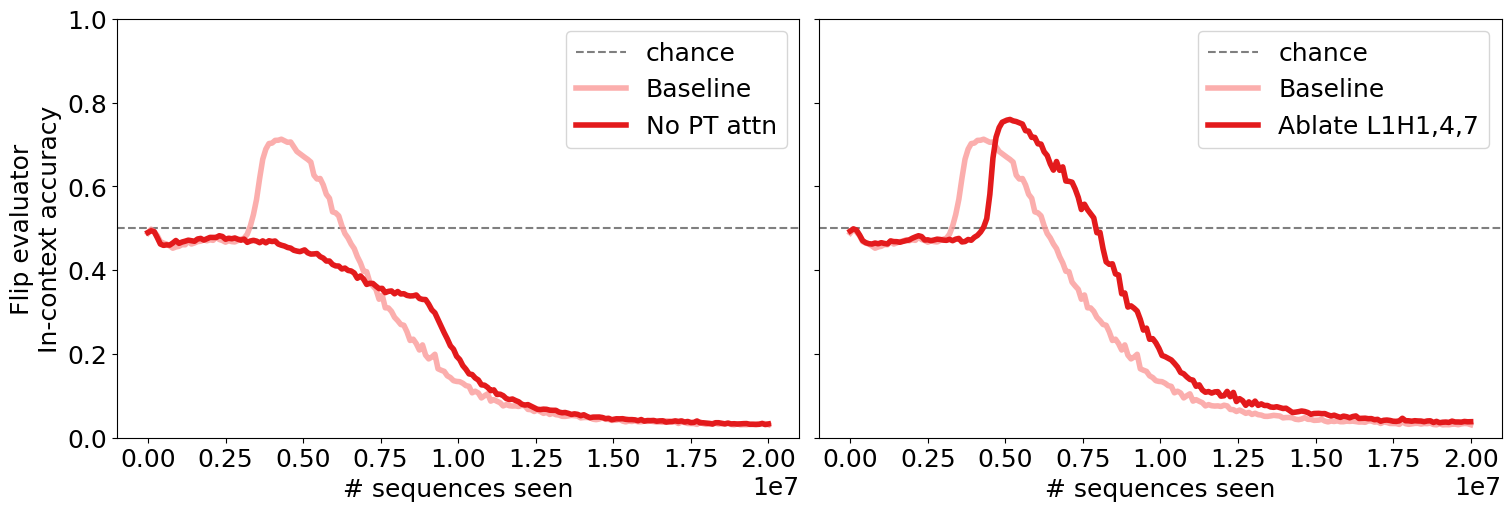

In [57]:
ablations = {'No PT attn': 'disallow_pt_head_attn_on_labels',
             'Ablate L1H1,4,7': 'nol0h147'}

matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True, squeeze=False)
fig.set_size_inches(15, 5)
lw=4
metric='in_context_acc'

to_plot = np.linspace(0, 2e7, 200)

# TODO(OSS) remove subsampling, just used to speed up plots)
# inds = np.linspace(0, f['eval_iter'].shape[0]-1, 100).astype(int)

f = h5.File(f'{base_folder}/{main_run}/log.h5', 'r')
raw_x = f['eval_iter'][:]
mask = visualize_runs.get_closest_inds(to_plot, raw_x)
e = 'flip_icl'
for i in range(2):
    axs[0,i].axhline(0.5, c='k', ls='--', label='chance', alpha=0.5)
    axs[0,i].plot(raw_x[mask], np.mean(f[e][metric][mask, :], axis=1), lw=lw, 
                  c=lighter_colors[evaluator_info[e]['c']],
                  alpha=0.8, label='Baseline')
    axs[0,i].set_xlabel("# sequences seen")
f.close()

for i, rl in enumerate(ablations):
    f = h5.File(f'{base_folder}/{ablations[rl]}/log.h5', 'r')
    raw_x = f['eval_iter'][:]
    mask = visualize_runs.get_closest_inds(to_plot, raw_x)
    axs[0,i].plot(raw_x[mask], np.mean(f[e][metric][mask, :], axis=1), lw=lw, c=evaluator_info[e]['c'], label=rl)
    f.close()


axs[0,0].legend()
axs[0,1].legend()
axs[0,0].set_ylabel("Flip evaluator\nIn-context accuracy")
axs[0,0].set_ylim(0,1)


fig.savefig(f'{save_folder}/appendix/rejected.pdf')